## binarsity illustration

In [1]:
# -*- coding: utf-8 -*-
%reset -f
%matplotlib inline
import os
import numpy as np
import pandas as pd
import pylab as pl
from sys import stdout
from prettytable import PrettyTable
from sklearn.preprocessing import StandardScaler
from mlpp.inference import LearnerLogReg
from mlpp.preprocessing import FeaturesBinarizer
import warnings
warnings.filterwarnings('ignore')

filename = 'churn'
#os.chdir('./datasets/%s' % filename)
data_folder = os.path.expanduser("~/Dev/datasets_binarsity/")

## Visualize data

In [2]:
X = pd.read_csv(data_folder + "%s/%s" % (filename, filename))

# drop first column (index)
X = X.drop(X.columns[[0]], axis=1)

# get label
idx_label_column = -1
y = X.iloc[:, idx_label_column]
y = 2 * (y.values != y.values[0]) - 1

# continuous features only
to_be_dropped = []
for i in range(X.shape[1]):
    feature_type = FeaturesBinarizer._detect_feature_type(X.ix[:,i])
    if feature_type == 'discrete':
        to_be_dropped.append(i)
X = X.drop(X.columns[to_be_dropped], axis=1)

print(X.shape)
X.head()

(3333, 14)


,Account Length,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70
1,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70
2,137,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29
3,84,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78
4,75,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73


### center and reduce data

In [3]:
standardscaler = StandardScaler()
X_std = standardscaler.fit_transform(X)

### Lasso logistic regression on raw features

In [4]:
beta_coeffs = list()
learner = LearnerLogReg(penalty='l1', C=1e2, solver='svrg', step=1e-3)
learner.fit(X_std, y)
beta_coeffs.append(learner.coef_)

### binarsity for different strength values

In [5]:
n_cuts = 30 # chosen by cross-val
binarizer = FeaturesBinarizer(n_cuts=n_cuts)
X_bin = binarizer.fit_transform(X)
blocks_start = binarizer.feature_indices[:-1, ]
blocks_length = binarizer.n_values

C_grid = [1e5, 1e3, 2e2]
for C_ in C_grid:
    learner = LearnerLogReg(penalty='binarsity', solver='svrg', C=C_,
                            step=1e-3, blocks_start=blocks_start,
                            blocks_length=blocks_length)
    learner.fit(X_bin, y)
    beta_coeffs.append(learner.coef_)

### display coeffs

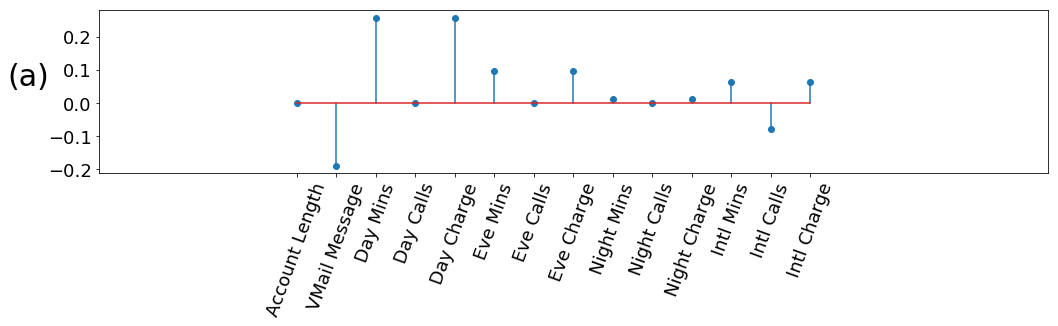

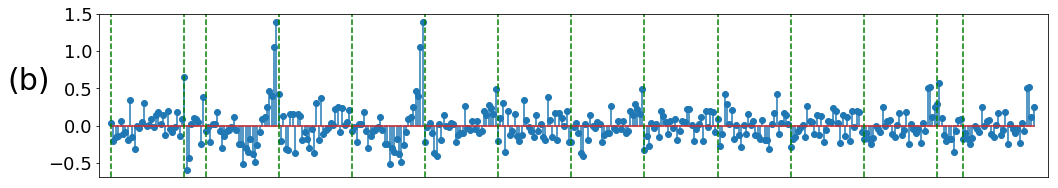

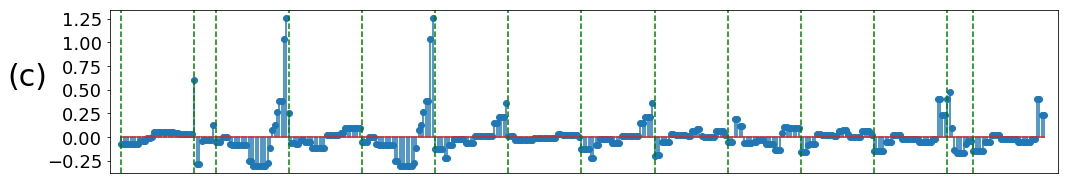

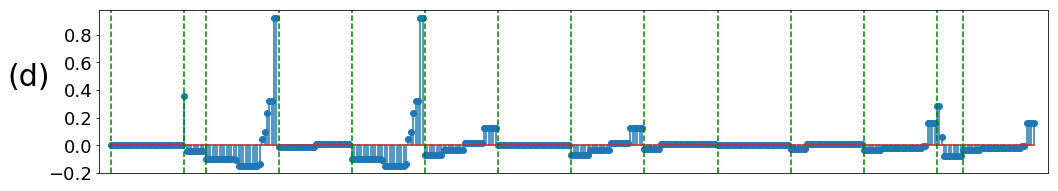

In [6]:
#from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
#rc('text', usetex=True)
figure_name = ['(a)', '(b)', '(c)', '(d)']
for i, coef in enumerate(beta_coeffs):
    fig = pl.figure(figsize=(17, 3))
    ax = fig.add_subplot(111)
    ax.stem(coef)
    ax.set_xlim([-5, len(coef)+5])
    if i == 0:
        #pl.suptitle("logisitic regression on raw features",
        #        fontsize=16, fontweight="bold")
        pl.xticks(range(len(coef)), 
                  [str(col).replace('_', ' ') for col in X.columns], 
                  rotation='70',
                  fontsize=18)
        pl.subplots_adjust(hspace=20)
    else:
        pl.tick_params(axis='x', which='both', bottom='off',
                       top='off', labelbottom='off')
        for val in blocks_start:
            #pl.suptitle("binarsity, lambda = %.1e" % C_grid[i-1],
            #        fontsize=14, fontweight="bold")
            ax.axvline(val, color='g', linestyle='--') 
    pl.yticks(fontsize = 18)
    ax.yaxis.labelpad = 20 
    pl.ylabel(r"%s" % figure_name[i], fontsize=30, rotation=0)
    #pl.savefig('./beta_paper/beta%s.pdf' % i, bbox_inches='tight')
    pl.show()